### Summery
<pre>
Author           : Anjana Tiha
Project Name     : "Image Recognition using Deep Convolutional Neural Network (Monkey Dataset)"
Description      : 1. Developed image recognition tool using Deep Convolutional Neural Network built 
                      from scratch with Keras Sequential model and, pretrained model “Inception” separately 
                      for fine-tuning with new class labels.
                   2. Trained on dataset - 10 Monkey species dataset (validation accuracy – 97.06%, 553MB).
Method           : 
Tools/Library    : Python, Keras, PyTorch, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.0
Last Update      : 11.25.2018
Comments         : Please use Anaconda editor for convenience.
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/anjanatiha/Image-Recognition-using-Deep-Convolutional-Neural-Network>Image Recognition using Deep Convolutional Neural Network (Monkey Dataset) (GitHub)</a>
GitLab Link      : <a href=https://gitlab.com/anjanatiha/Image-Recognition-using-Deep-Convolutional-Neural-Network>Image Recognition using Deep Convolutional Neural Network (Monkey Dataset) (GitLab)</a>
Portfolio        : <a href=https://anjanatiha.wixsite.com/website>Anjana Tiha's Portfolio</a>
</pre>

#### Dataset

<pre>
Dataset Name     : 10 Monkey Species
Dataset Link     : <a href=https://www.kaggle.com/slothkong/10-monkey-species>10 Monkey Species</a>
</pre>

#### Library/Tools Version
- Python - v3.6.7
- argparse
- random
- numpy
- shutil
- gc
- re
- Keras - 2.2.4
- Keras-preprocessing - v1.0.5
- TensorFlow - 1.12
- PIL/Pillow - 5.1.0
- Matplotlib - 2.2.2
- scikit-learn - 0.19.1
- mlxtend - 0.14.0

#### Commands / Running Instruction
<pre>
tensorboard --logdir=logs
%config IPCompleter.greedy=True
</pre>

<pre>
<b>Dataset Details</b>
Dataset Name            : Monkey Dataset
Number of Class         : 10
Number/Size of Images   : Total      : 1370 (553 Megabyte (MB))
                          Training   : 1098 (434 Megabyte (MB))
                          Validation : 272  (119 Megabyte (MB))
                          Testing    : 0    (0   Megabyte (MB))

<b>Model Parameters</b>
Machine Learning Library: Keras
Base Model              : InceptionV3
Optimizers              : Adam
Loss Function           : categorical_crossentropy

<b>Training Parameters</b>
Batch Size              : 64
Number of Epochs        : 50
Training Time           : 40 min

<b>Output (Prediction/ Recognition / Classification Metrics)</b>
<b>Validation</b>
Accuracy                : 97.0%
Loss                    : 0.11

<!--
<b>Testing</b>
Accuracy                : 
Loss                    : 
Precision               : 
Recall                  : 
Specificity             : -->
</pre>

<!--
Best Model Path (Accuracy): 27-val_acc-0.97-val_loss-0.11.hdf5
Best Test Accuracy: 97.0%
Best Test Loss: 0.11
-->

##### Imports

In [1]:
from __future__ import print_function

import argparse
import sys
import os

import random

import time

import numpy as np

import shutil

import gc

import re

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras import optimizers

from keras import backend as K

import tensorflow as tf

from IPython.display import display
from PIL import Image

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix



C:\Users\Andromeda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Functions:
<pre>
Resetting model and log directory
class name cleansing
</pre>

In [2]:
# make or reset directory
def mk_reset_dir(directory):
    if os.path.exists(directory):
        try:
            shutil.rmtree(directory)
            os.mkdir(directory)
        except:
            print("error:", directory)
    else:
        try:
            os.mkdir(directory)
        except:
            print("error create:", directory)
            

def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


### Setting Data / Output Directory
<pre>
Data             : training, validation, testing
Model and output : model directory and logs directory
</pre>

In [3]:
# setting data path data seperated by class name
training_dir = r"data/input/training"
testing_dir = r"data/input/testing"
validation_dir = r'data/input/validation'

# setting output directory
model_dir = r"data/output/models/"
log_dir = r"data/output/logs"

In [4]:
# model_dir

#### Resetting Output Directory

In [5]:
# mk_reset_dir(model_dir)
# mk_reset_dir(log_dir)

#### Setting Parameters for Image Transformation
Training, Validation, Testing and  Dataset 

In [8]:
# Set number of class
num_class = len(os.listdir(training_dir))

# setting training parameters
norm = 255.0
rescale=1./norm
shear_range=0.2
zoom_range=0.2
horizontal_flip=True

# setting train, test, validation parameters
target_size=(224, 224)
# batch_size=32
batch_size=64
class_mode='categorical'

loss='categorical_crossentropy'
# metrics=['accuracy', 'binary_accuracy', precision, recall]
metrics=['accuracy']

epochs = 50
verbose = 1

In [9]:
model_file = model_dir+"{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"
# model_file = "weights-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"
model_file

'data/output/models/{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5'

#### Transforming Image Dataset for Training, Validation, Testing

In [10]:
# data generator for training
train_datagen = ImageDataGenerator(
        rescale=rescale,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for validation
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for testing
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


#### Model Import and Parameter Setting

<p>1. Importing Pretrained model InceptionV3 <br>
   2. Disable training on first few layers <br>
   3. Enable training on top and output layers<br>
   4. Adjust output Dense Layer to number of Image Class <br>
   5. Setting model parameters like optimizer and metrics <br>
</p>

In [11]:
# importing inception model
base_model = InceptionV3(weights='imagenet', include_top=False)

# setting model layers specially output layer with class number
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

#loading model
model = Model(inputs=base_model.input, outputs=predictions)


#print layers of inception model
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
    
    
# set all laeyrs as untrainable
for layer in base_model.layers:
    layer.trainable = False
    
# train the top inception layers 
# freeze first 249 layers
# unfreeze the rest
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
    
# set optimizer
sgd = optimizers.Adam()
# sgd = optimizers.Adam(lr=0.001)
# sgd = optimizers.Adam(lr=0.0001)
# sgd = optimizers.SGD()
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = optimizer=SGD(lr=0.0001, momentum=0.9)

# compile model with optimizer and loss
model.compile(sgd, loss=loss, metrics=metrics)

#### CheckPoint, and Callbacks (TensorBoard, Early Stopping, Reduce Learning rate) Setting

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

# tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=1, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
# tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, batch_size=32, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

tensorboard.set_model(model) 


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)

# callbacks_list = [checkpoint, tensorboard, early_stopping]
# callbacks_list = [reduce_lr, checkpoint, tensorboard, early_stopping]
callbacks_list = [reduce_lr, checkpoint, tensorboard]

### Model Training 
#### Training model with given parameters

In [13]:
# train inception model
# fine-tuning the top layers
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    steps_per_epoch = len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_list)

Epoch 1/50
18/18 [==============================] - 77s 4s/step - loss: 0.8123 - acc: 0.7606 - val_loss: 1.1195 - val_acc: 0.8897
Epoch 2/50
18/18 [==============================] - 24s 1s/step - loss: 0.3226 - acc: 0.9236 - val_loss: 2.7383 - val_acc: 0.7537
Epoch 3/50
18/18 [==============================] - 48s 3s/step - loss: 0.1745 - acc: 0.9480 - val_loss: 0.6596 - val_acc: 0.9154
Epoch 4/50
18/18 [==============================] - 40s 2s/step - loss: 0.1287 - acc: 0.9723 - val_loss: 0.7875 - val_acc: 0.8897
Epoch 5/50
18/18 [==============================] - 36s 2s/step - loss: 0.1261 - acc: 0.9671 - val_loss: 1.8350 - val_acc: 0.7426
Epoch 6/50
18/18 [==============================] - 38s 2s/step - loss: 0.1136 - acc: 0.9791 - val_loss: 1.4010 - val_acc: 0.8272
Epoch 7/50
18/18 [==============================] - 37s 2s/step - loss: 0.1147 - acc: 0.9800 - val_loss: 1.1619 - val_acc: 0.7647
Epoch 8/50
18/18 [==============================] - 46s 3s/step - loss: 0.0805 - acc: 0.98

#### Plotting Training and Validation Performance over the Epochs

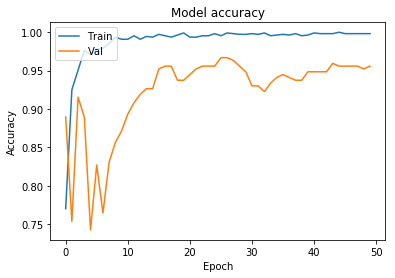

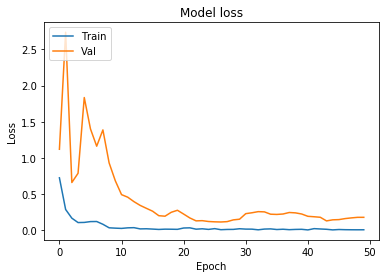

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### Retraining Best Model

###### Selecting Best Model and Parameters for Retraining

In [ ]:
# setting retraining from old model
model_path = "data/output/models/"+"50-val_acc-0.96-val_loss-0.18.hdf5"
# model_path = model_+"\\data\\outputs\\models\\"+"modelsweights-03-val_acc-0.89-val_loss-0.28.hdf5"
epochs=15
verbose=1

###### Loading Best Model for Retraining

In [ ]:
model = keras.models.load_model(model_path)

##### Retrain the selected best model

In [ ]:
# retrain by loading last good model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list)

##### Testing all saved model from each epochs to check for the best model based on test dataset image recognition performance

In [ ]:
# testing model

details = False
best_accuracy = 0
best_loss = 0

lowest_accuracy = 100
lowest_loss = 1000000

models_path = "data\\output\\models\\"

best_model_acc = ""
best_model_loss = ""

models_arr = []
accuracy_arr = []
loss_arr = []

model_files = os.listdir(models_path)

i=0
for model_file in model_files:
    model_path = models_path+"\\"+model_file
    try:
        del model
    except:
        pass
    tf.reset_default_graph()
    K.clear_session()
    gc.collect()
    
    model = keras.models.load_model(model_path)
    
    result = model.evaluate_generator(generator=test_generator, steps=len(test_generator))
    
    accuracy = result[1]*100
    loss = result[0]
    
    accuracy_arr.append(accuracy)
    loss_arr.append(loss)
    models_arr.append(model_path)
    
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        best_loss = loss
        best_model_acc=model_path
        
    if loss<lowest_loss:
        lowest_accuracy = accuracy
        lowest_loss = loss
        best_model_loss=model_path
        
    if details:
        print("%s%s"%("Model No: ", i))
        print("%s%s"%("Model File Path: ", model_file))
        print("*"*80)
        print("%s%.2f%s"% ("Current Accuracy: ", accuracy, "%"))
        print("%s%.2f"% ("Current Loss: ", loss))

        print("-"*80)
        print("-"*80)
        
        print("%s%.2f%s"% ("Best Test Accuracy (Accuracy wise):", best_accuracy, "%"))
        print("%s%.2f"% ("Best Test Loss (Accuracy wise): ", best_loss))

        print("-"*80)

        print("%s%.2f%s"% ("Best Test Accuracy (Loss wise): ", lowest_accuracy, "%"))
        print("%s%.2f"% ("Best Test Loss (Loss wise): ", lowest_loss))
        print(" "*80)

    elif i%10==0:
        print("%s%s"%("Model No: ", i))
        print("%s%s"%("Model File Path: ", model_file))
        print("*"*80)
        
        print("%s%.2f%s"% ("Best Test Accuracy: ", best_accuracy, "%"))
        print("%s%.2f"% ("Best Test Loss: ", best_loss))

        print("-"*80)

        print("%s%.2f%s"% ("Best Test Accuracy (Loss wise): ", lowest_accuracy, "%"))
        print("%s%.2f"% ("Best Test Loss (Loss wise): ", lowest_loss))
        print(" "*80)
    
    i+=1

##### Printing best model accuracy and loss

In [ ]:
print("-"*17,"Summary of Model Performance on Test Dataset", "-"*17)

print("%s%s"% ("Best Model Path (Accuracy): ", best_model_acc))
print("%s%.2f%s"% ("Best Test Accuracy: ", best_accuracy, "%"))
print("%s%.2f"% ("Best Test Loss: ", best_loss))

print("-"*100)
print("-"*100)

print("%s%s"% ("Best Model Path (Loss): ", best_model_loss))
print("%s%.2f%s"% ("Best Test Accuracy: ", lowest_accuracy, "%"))
print("%s%.2f"% ("Best Test Loss: ", lowest_loss))

#### Plotting all model performance over all epochs and models for accuracy and loss

In [ ]:
x_axis_arr = np.arange(len(accuracy_arr))
plt.title("Test Dataset Performance (Accuracy)")
plt.plot(x_axis_arr, accuracy_arr)
plt.xlabel("Iteration Number")
plt.ylabel("Accuracy (100%)")
plt.show()

x_axis_arr = np.arange(len(loss_arr))
plt.title("Test Dataset Performance (Loss)")
plt.plot(x_axis_arr, loss_arr)
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.show()

##### Selecting Best Model for full evaluation

In [17]:
# model_path = "data/output/models/"+"17-val_acc-0.82-val_loss-0.42.hdf5"

# Best Recall
# model_path = "data/output/models/"+"50-val_acc-0.69-val_loss-1.21.hdf5"

model_path = "data/output/models/"+"27-val_acc-0.97-val_loss-0.11.hdf5"


##### Using validation dataset as no test set available !!!

In [19]:
test_generator = validation_generator

##### Evaluate Best Model for Validation Dataset

In [20]:
# testing model
model = keras.models.load_model(model_path)
result = model.evaluate_generator(generator=validation_generator, steps=len(validation_generator))
print("-"*17,"Summary of Best Model Performance on Test Dataset", "-"*17)
print("%s%.2f%s"% ("Test Accuracy: ", result[1]*100, "%"))
print("%s%.2f"% ("Test Loss: ", result[0]))

----------------- Summary of Best Model Performance on Test Dataset -----------------
Test Accuracy: 96.32%
Test Loss: 0.12


##### Selecting Best Model for further analysis, evaluation and visualization

In [22]:
# testing model
model = keras.models.load_model(model_path)
preds = model.predict_generator(test_generator, steps=len(test_generator))
y_classes = preds.argmax(axis=-1)

In [27]:
monkey_labels = {"n0": "Latin: alouatta_palliata, Common: mantled_howler",
                 "n1": "Latin: erythrocebus_patas,  Common: patas_monkey",
                 "n2": "Latin: cacajao_calvus,  Common: bald_uakari",
                 "n3": "Latin: macaca_fuscata,  Common: japanese_macaque",
                 "n4": "Latin: cebuella_pygmea,  Common: pygmy_marmoset",
                 "n5": "Latin: cebus_capucinus,  Common: white_headed_capuchin",
                 "n6": "Latin: mico_argentatus,  Common: silvery_marmoset",
                 "n7": "Latin: saimiri_sciureus,  Common: common_squirrel_monkey",
                 "n8": "Latin: aotus_nigriceps,  Common: black_headed_night_monkey",
                 "n9": "Latin: trachypithecus_johnii,  Common: nilgiri_langur"}

monkey_labels_common = {"n0": "mantled_howler",
                 "n1": "patas_monkey",
                 "n2": "bald_uakari",
                 "n3": "japanese_macaque",
                 "n4": "pygmy_marmoset",
                 "n5": "white_headed_capuchin",
                 "n6": "silvery_marmoset",
                 "n7": "common_squirrel_monkey",
                 "n8": "black_headed_night_monkey",
                 "n9": "nilgiri_langur"}

##### Showing Confusion Matrix of Model Performance for Test Dataset

In [34]:
target_names = [name_correct(monkey_labels_common[k]) for k in os.listdir(training_dir)]

# CM = confusion_matrix(test_generator.classes, y_classes)
# fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
# plt.xticks(range(2), target_names, fontsize=16)
# plt.yticks(range(2), target_names, fontsize=16)
# plt.show()

##### Showing precision, recall, f1-score, support for Model Performance over Test Dataset

In [44]:
print(classification_report(test_generator.classes, y_classes, target_names=target_names))

                           precision    recall  f1-score   support

           Mantled Howler       0.03      0.04      0.04        26
             Patas Monkey       0.13      0.14      0.14        28
              Bald Uakari       0.07      0.07      0.07        27
         Japanese Macaque       0.07      0.07      0.07        30
           Pygmy Marmoset       0.08      0.08      0.08        26
    White Headed Capuchin       0.07      0.07      0.07        28
         Silvery Marmoset       0.04      0.04      0.04        26
   Common Squirrel Monkey       0.17      0.18      0.18        28
Black Headed Night Monkey       0.08      0.07      0.08        27
           Nilgiri Langur       0.09      0.08      0.08        26

              avg / total       0.08      0.08      0.08       272



##### Showing calcualted precision, recall for Model over Test Dataset

In [37]:
# # Calculate Precision and Recall
# tn, fp, fn, tp = CM.ravel()

# precision = tp/(tp+fp)
# recall = tp/(tp+fn)

# print("Recall of the model is {:.2f}".format(recall))
# print("Precision of the model is {:.2f}".format(precision))

##### Retriving actual labels 

In [47]:
label_map = (test_generator.class_indices)
label_map_rev = {v: name_correct(monkey_labels_common[k]) for k,v in label_map.items()}
num_batch_t = len(test_generator)
print(label_map)
print(label_map_rev)

{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
{0: 'Mantled Howler', 1: 'Patas Monkey', 2: 'Bald Uakari', 3: 'Japanese Macaque', 4: 'Pygmy Marmoset', 5: 'White Headed Capuchin', 6: 'Silvery Marmoset', 7: 'Common Squirrel Monkey', 8: 'Black Headed Night Monkey', 9: 'Nilgiri Langur'}


##### Showing accuracy for Model over Single Batch of Test Dataset

In [48]:
num = random.randint(0, num_batch_t-1)

y_img_batch, y_class_batch = test_generator[num] 

y_pred = np.argmax(model.predict(y_img_batch),-1)
y_true = np.argmax(y_class_batch,-1)

print("Selected Batch No: %d\nBatch Size: %d"%(num, len(y_pred)))
print("Accuracy : ", sum(y_pred==y_true)/batch_size*100, "%")

y_true_labels = [label_map_rev[c] for c in y_true]
y_pred_labels = [label_map_rev[c] for c in y_pred]

batch_size_t = len(y_true_labels)

Selected Batch No: 1
Batch Size: 64
Accuracy :  95.3125 %


### Visualization 
Visualization of performance of a random test dataset batch and few random images from a batch

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

Setting parameters for visualization 1

In [49]:
figure_directory = "data/output/figures"
image_file_name = figure_directory+"/result"

dpi=100

update_image = True


cols = 4
rows= batch_size_t/cols
if batch_size_t%cols==0:
    rows = int(batch_size_t/cols)
else:
    rows = int(batch_size_t/cols)+1
    
figsize_col = cols*2
figsize_row = rows*2

hspace = 0.5
wspace = 0.3

facecolor='w'
edgecolor='k'

titlesize = 'small'

true_prediction_label_color='black'
false_prediction_label_color='red'

true_label_title_prefix = "org: "
pred_label_title_prefix = "pred: "

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

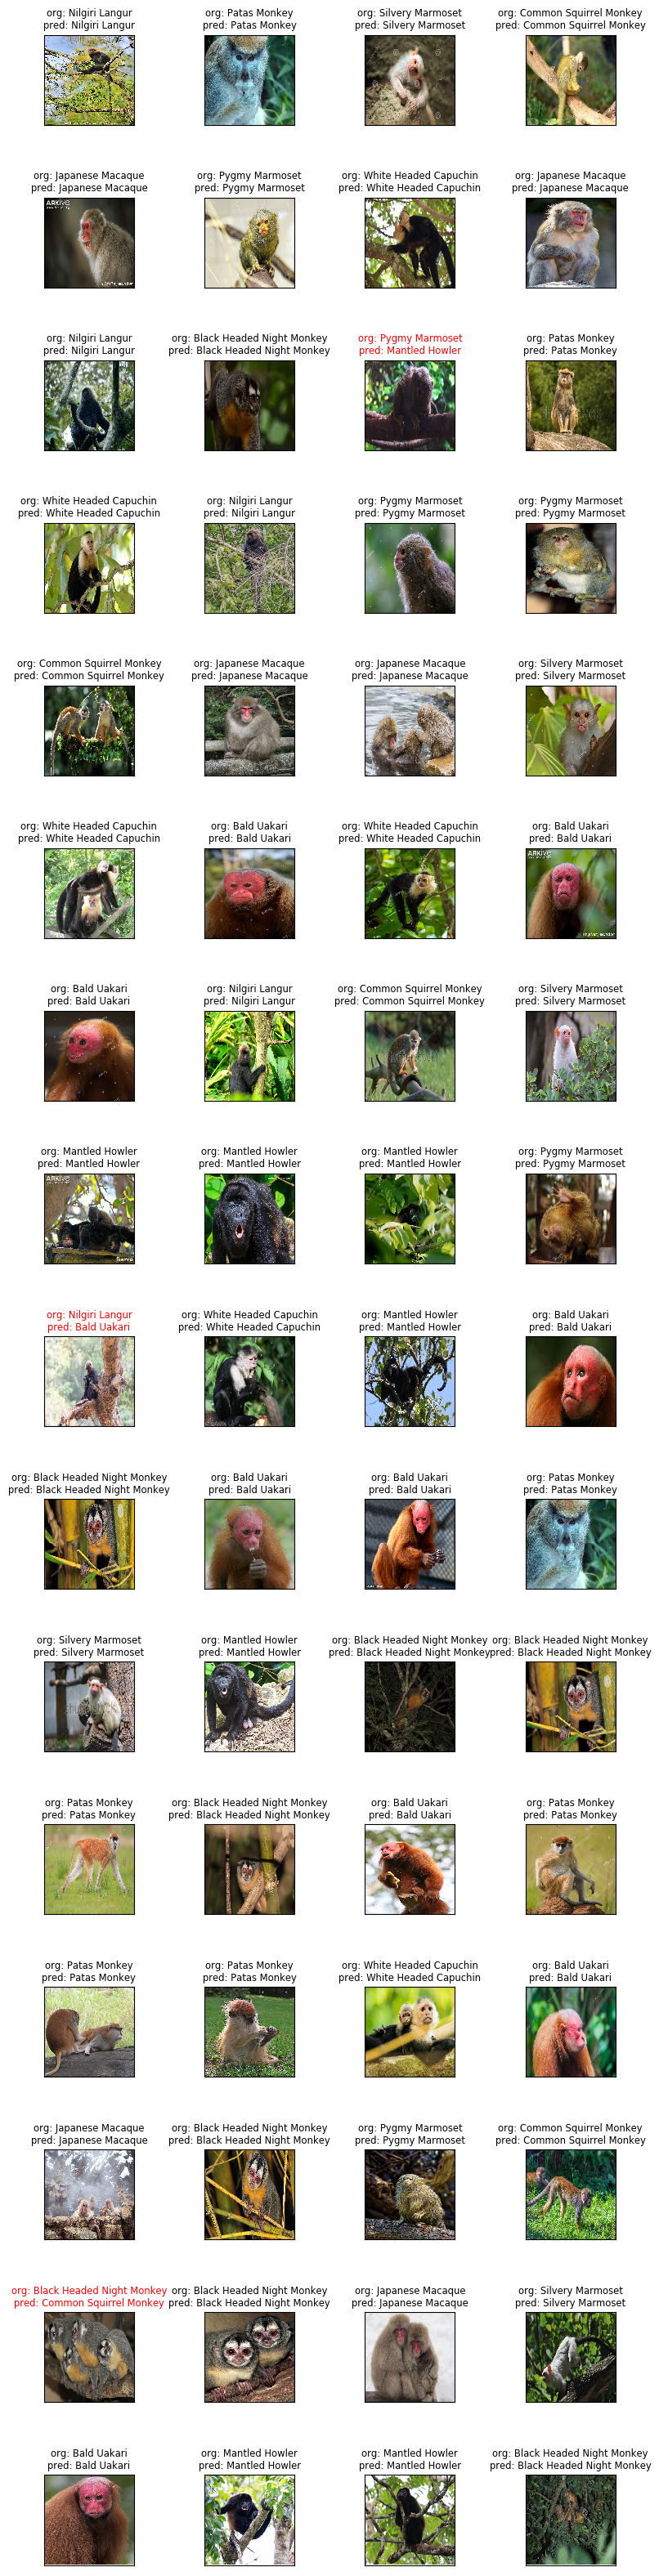

In [51]:
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_col, figsize_row),
                        dpi=dpi, facecolor=facecolor, edgecolor=edgecolor,
                        subplot_kw={'xticks': [], 'yticks': []})


plt.rcParams.update({'axes.titlesize': titlesize})
plt.subplots_adjust(hspace=hspace, wspace=wspace)

for i in range(0, batch_size_t): # how many imgs will show from the mxn grid
    plt.subplot(rows, cols, i+1)
    
    plt.imshow(y_img_batch[i])
    
    plt.xticks([])
    plt.yticks([])
    
    if y_true_labels[i]==y_pred_labels[i]:
        plt.title(true_label_title_prefix + y_true_labels[i] + "\n" + pred_label_title_prefix + y_pred_labels[i])
    else:
        plt.title(true_label_title_prefix + y_true_labels[i] + "\n" + pred_label_title_prefix + y_pred_labels[i], color=false_prediction_label_color)
        
    if update_image and os.path.exists(image_file_name):
        os.remove(image_file_name)
    
    fig.savefig(image_file_name, dpi=dpi)

plt.tight_layout()
plt.show()

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

Setting parameters for visualization 2

In [52]:
figure_directory = "data/output/figures"
image_file_name = figure_directory+"/sample"

dpi=100

update_image = True

cols = 4
rows= 2

count = rows*cols
    
figsize_col = cols*2
figsize_row = rows*2

hspace = 0.5
wspace = 0.3

titlesize = 'small'

true_prediction_label_color='black'
false_prediction_label_color='red'

true_label_title_prefix = "org: "
pred_label_title_prefix = "pred: "

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

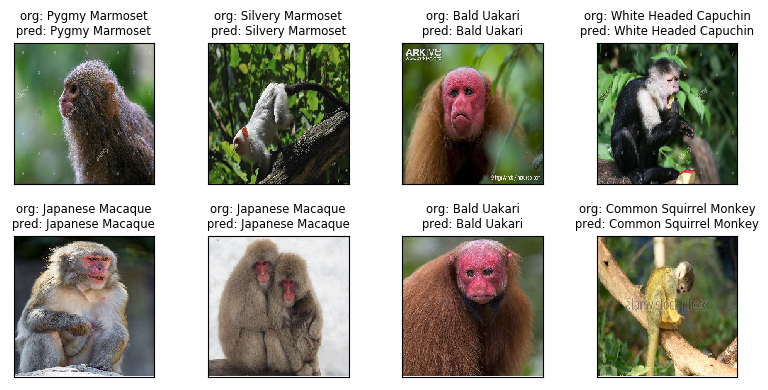

In [56]:
# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_col, figsize_row),
                        dpi=dpi, facecolor=facecolor, edgecolor=edgecolor,
                        subplot_kw={'xticks': [], 'yticks': []})

plt.rcParams.update({'axes.titlesize': titlesize})
plt.subplots_adjust(hspace=hspace, wspace=wspace)


batch_size_tmp = batch_size_t

m = {}

for i in range(0, count): # how many imgs will show from the mxn grid
    while num in m:
        num = random.randint(0, batch_size_tmp-1)
    
    m[num]=1
    
    plt.subplot(rows, cols, i+1)
    
    plt.imshow(y_img_batch[num])
    
    plt.xticks([])
    plt.yticks([])
    
    if y_true_labels[num]==y_pred_labels[num]:
        plt.title(true_label_title_prefix + y_true_labels[num] + "\n" + pred_label_title_prefix + y_pred_labels[num])
    else:
        plt.title(true_label_title_prefix + y_true_labels[num] + "\n" + pred_label_title_prefix + y_pred_labels[num], color=false_prediction_label_color)
    
   
    if update_image and os.path.exists(image_file_name):
        os.remove(image_file_name)   
    
    fig.savefig(image_file_name, dpi=dpi)


plt.tight_layout()
plt.show()